#Лабораторна робота 3

**Виконала** студентка групи КІ-41мп Додонова Марія.

##Завдання

1. Обрати метод для прогнозування - базуючись на отриманих складових часового ряду, обрати моделі (обрати 2-3 моделі), за якими буде побудовано прогноз
2. Перевірити наявність гетероскедастичності часового ряду
3. Побудувати модель: Перевірити показники якості моделі
4. Побудувати прогноз: Перевірити показники якості прогнозу
5. Статистичні характеристики навести у таблиці
6. Вивести всі проміжні графіки

##Виконання роботи

### Завантаження датасету

Завантаження попередньо оброблених даних у лабораторній роботі 2 датасету Gurugram's Air Quality Index Time-Series Dataset із сайту kaggle.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the DataFrame from a CSV file
df = pd.read_csv("/data/decomposed_sector_51_daily_aqi.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.head()

,AQI,Smoothed,Trend,Seasonal,Residuals
Date,,,,,
2020-03-05,73.0,73.0,NaN,0.865830,NaN
2020-03-06,55.0,55.0,NaN,0.907275,NaN
2020-03-07,78.0,101.0,NaN,0.904282,NaN
2020-03-08,120.0,131.2,NaN,0.914981,NaN
2020-03-09,179.0,141.4,NaN,0.980246,NaN


Зобразимо часовий ряд та його компоненти графічно.

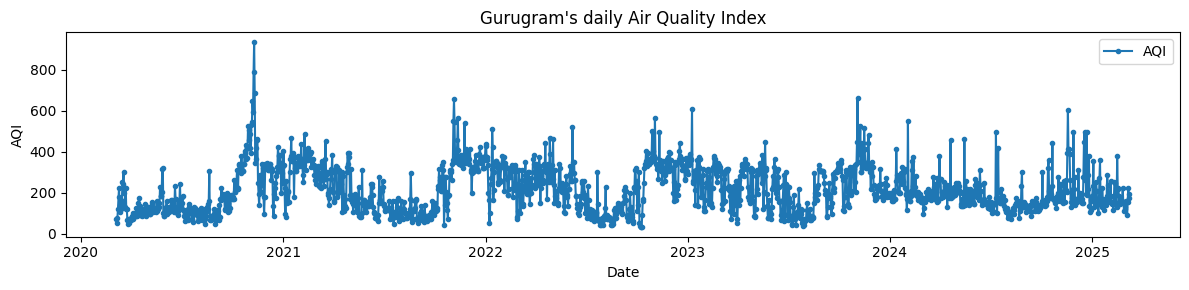

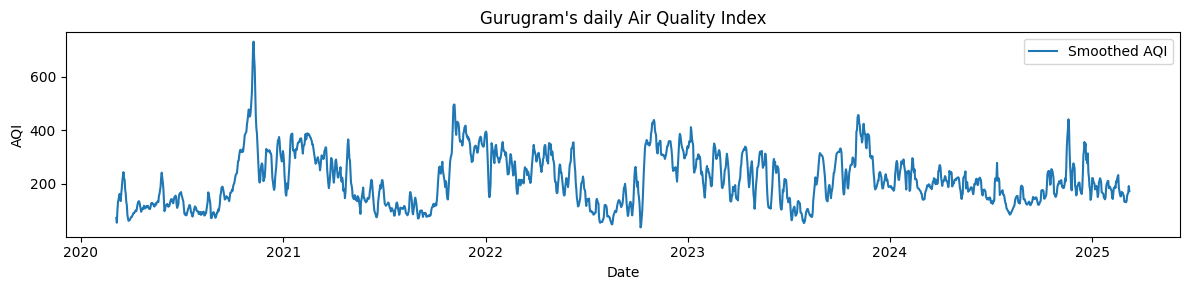

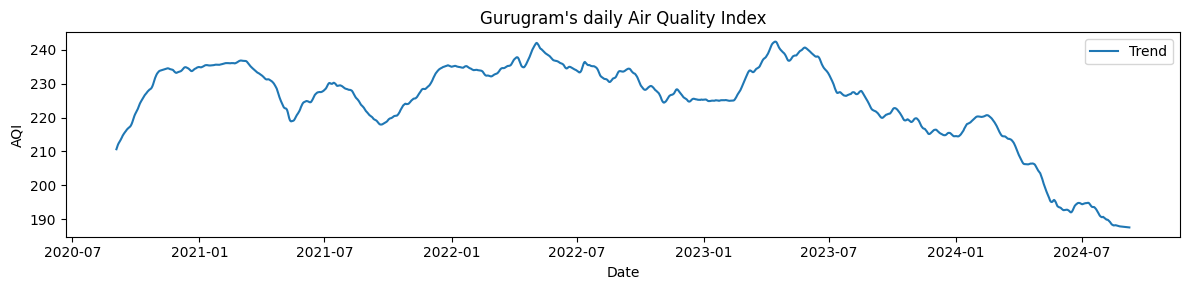

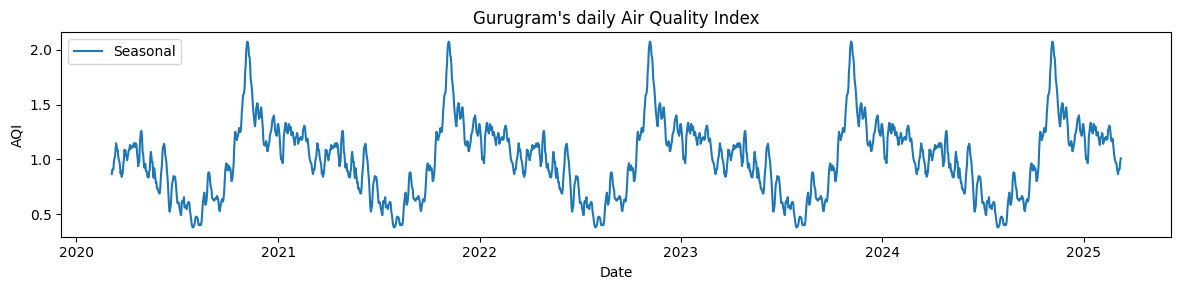

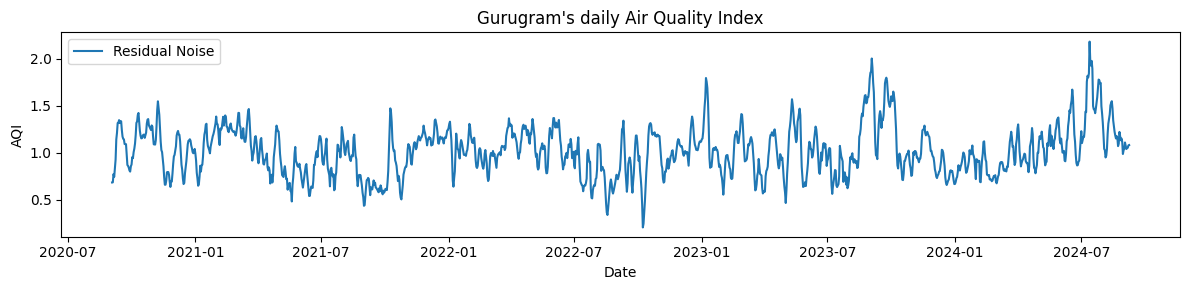

In [ ]:
# Plot the time series
def plot_time_series(timeseries, forecast=None, label=None,
                     smoothed=None, lr_name=None, marker=None,
                     title="Gurugram's daily Air Quality Index"):
  plt.figure(figsize=(12, 3))

  # Plot the main time series data
  plt.plot(timeseries, marker=marker, markersize=3,
           label=label or "AQI")

  # Plot forecast
  if forecast is not None:
    plt.plot(forecast, label="Forecast")

  # Plot the smoothed data if available
  if smoothed is not None:
    plt.plot(smoothed, linestyle="--", label="Smoothed AQI")

  plt.xlabel("Date")
  plt.ylabel("AQI")
  plt.title(title)
  plt.legend()
  plt.tight_layout()

  plt.show()


plot_time_series(df["AQI"], marker="o")
plot_time_series(df["Smoothed"], label="Smoothed AQI")
plot_time_series(df["Trend"], label="Trend")
plot_time_series(df["Seasonal"], label="Seasonal")
plot_time_series(df["Residuals"], label="Residual Noise")

###Вибір методу прогнозування та моделей

Представлений часовий ряд є стаціонарним (продемонстровано у лабораторній роботі 2), тобто у ньому відсутній тренд. Але цьому ряду властива сезонність. Тому для прогнозування оберемо моделі Хольта-Вінтерса, Prophet та SARIMA.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

###Перевірка наявності гетероскедастичності часового ряду

Гетероскедастичність у часовому ряді означає, що дисперсія змінюється з часом. Побудуємо графік залишків ряду, отриманий у попередній лабораторній роботі та візуально оцінимо його.

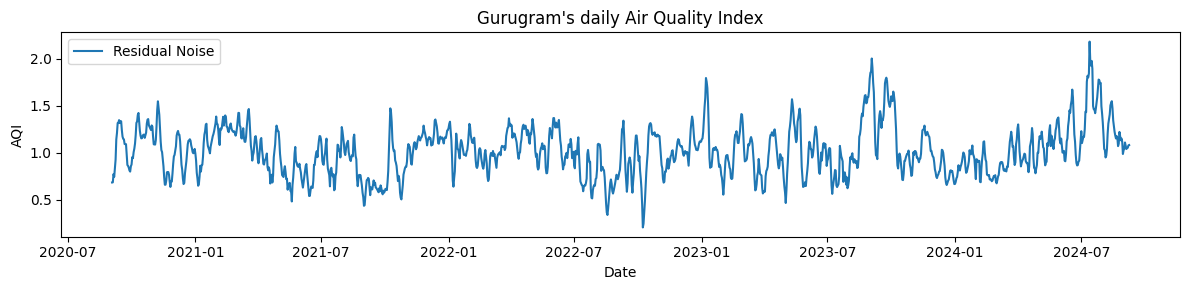

In [ ]:
plot_time_series(df["Residuals"], label="Residual Noise")

Бачимо, що на графіку присутні ділянки звуження та розширення. Можливо ряду характерна гетероскедастичність.

Побудуємо графік рухомого стандартного відхилення.

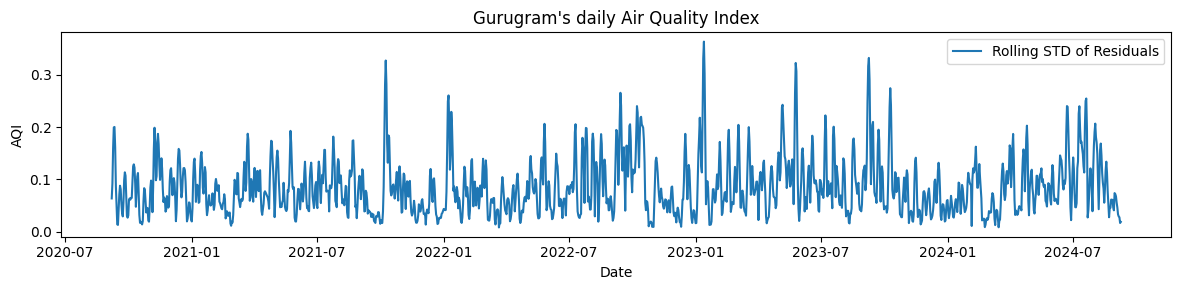

In [ ]:
stds = df["Residuals"].rolling(window=5).std()
plot_time_series(stds, label="Rolling STD of Residuals")

Оскільки рухоме стандартне відхилення змінюється досить сильно, можемо зробити висновок про гетероскедастичність ряду.

###Побудова моделі та перевірка показників якості моделі

#### Holt-Winters

Розділимо датасет на вибірки для тренування та тестування моделі Хольта-Вінтерса та відобразимо їх.

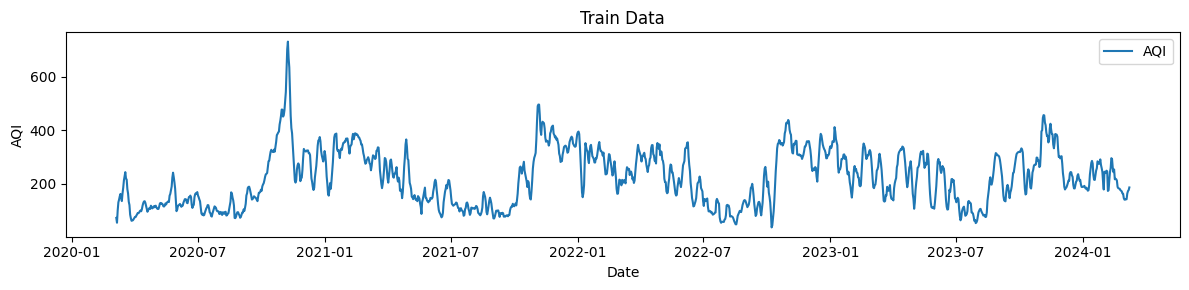

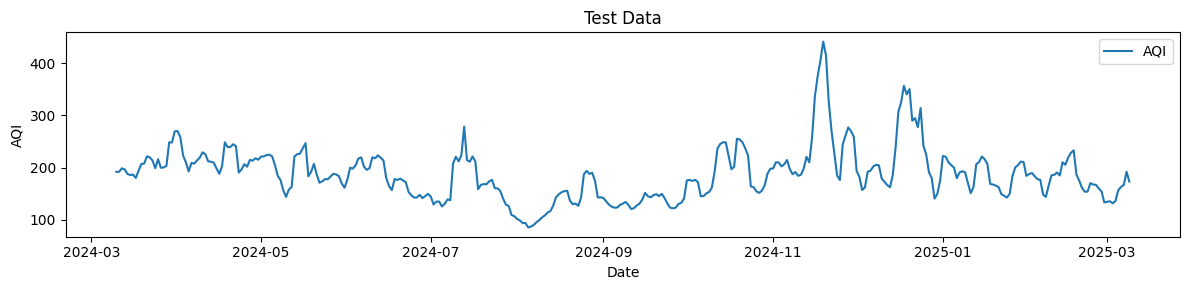

In [ ]:
hw_test_size = 365
hw_train_size = len(df) - hw_test_size
hw_train_df = df[:hw_train_size-1]
hw_test_df = df[hw_train_size:]

plot_time_series(hw_train_df["Smoothed"], title="Train Data")
plot_time_series(hw_test_df["Smoothed"], title="Test Data")

Проведемо тренування моделі та відобразимо результат прогнозування на тренувальних даних.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


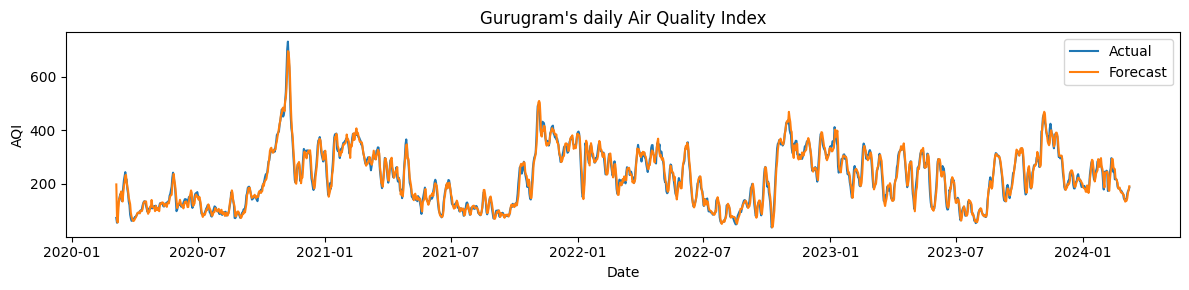

In [ ]:
hw = ExponentialSmoothing(hw_train_df["Smoothed"], trend=None, seasonal="mul", seasonal_periods=365)
hw_fit = hw.fit()

hw_preds = hw_fit.predict(start=0, end=len(hw_train_df)-1)
hw_preds.name = "Prediction"
plot_time_series(hw_train_df["Smoothed"], label="Actual", forecast=hw_preds)

Створимо структуру для збереження результатів оцінювання моделей та прогнозів.

In [ ]:
statistics = {
    "model": [], "sse": [], "r2": [],
    "dw": [], "aic": [], "bic": [],
    "mse": [], "mae": [], "mape": []
}

Виконаємо оцінювання моделі Хольта-Вінтерса за наступними критеріями: сума квадратів похибок (SSE), коефіцієнт детермінації (R2), критерій Дарбіна-Уотсона (DW), критерій Акаіке (AIC), критерій Шварца (BIC). Також відобразимо графік залишків.

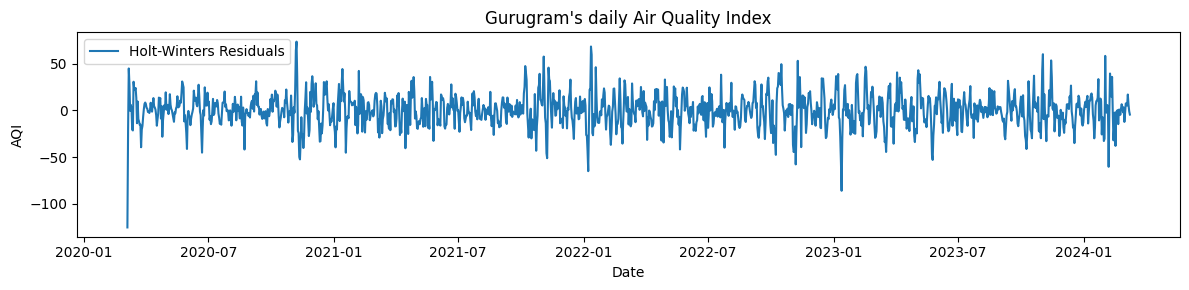

Model: HOLT-WINTERS
SSE: 455543.0273
R2: 0.9704
DW: 0.9422
AIC: 8428.5652
BIC: 8481.4613


In [ ]:
statistics["model"].append("holt-winters")

# SSE
statistics["sse"].append(hw_fit.sse)

# R2
statistics["r2"].append(r2_score(hw_train_df["Smoothed"], hw_preds))

# DW
hw_residuals = hw_fit.resid
statistics["dw"].append(durbin_watson(hw_residuals))

# AIC, BIC
hw_n = len(hw_train_df)
hw_rss = np.sum(hw_residuals**2)
hw_k = len(hw_fit.params)

statistics["aic"].append(hw_n * np.log(hw_rss / hw_n) + 2 * hw_k)
statistics["bic"].append(hw_n * np.log(hw_rss / hw_n) + hw_k * np.log(hw_n))

plot_time_series(hw_residuals, label="Holt-Winters Residuals")
for k, v in statistics.items():
  if k == "model":
    print(f"{k.capitalize()}: {v[0].upper()}")
    continue
  if len(v) != 0:
    print(f"{k.upper()}: {float(v[0]):.4f}")

#### Prophet

Розділимо датасет на вибірки для тренування та тестування моделі Prophet.

In [ ]:
prophet_test_size = 365
prophet_train_size = len(df) - prophet_test_size

df_prophet = df.reset_index()[["Date", "Smoothed"]].rename(columns={
    "Date": "ds",
    "Smoothed": "y"
})
train_df_prophet = df_prophet[:prophet_train_size-1]
test_df_prophet = df_prophet[prophet_train_size:]

Проведемо тренування моделі та відобразимо результат прогнозування на тренувальних даних.

DEBUG:cmdstanpy:input tempfile: /tmp/tmp27guq04v/m6ulbysz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp27guq04v/xvk9imdk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52401', 'data', 'file=/tmp/tmp27guq04v/m6ulbysz.json', 'init=/tmp/tmp27guq04v/xvk9imdk.json', 'output', 'file=/tmp/tmp27guq04v/prophet_model5gsntsy5/prophet_model-20250522103300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:33:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:33:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


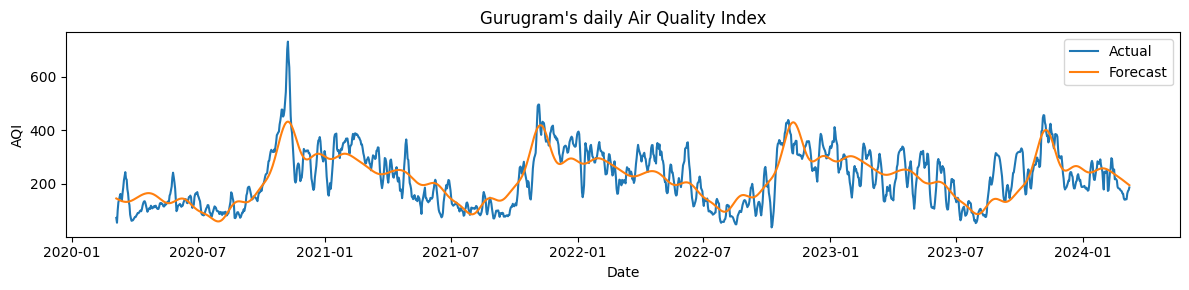

In [ ]:
prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet.fit(train_df_prophet)

future = prophet.make_future_dataframe(periods=len(train_df_prophet)+1)
forecast = prophet.predict(future)
prophet_preds = forecast[forecast["ds"].isin(train_df_prophet["ds"])]
plot_time_series(train_df_prophet.set_index("ds")["y"], label="Actual", forecast=prophet_preds.set_index("ds")["yhat"])

Виконаємо оцінювання моделі за наступними критеріями: сума квадратів похибок (SSE), коефіцієнт детермінації (R2), критерій Дарбіна-Уотсона (DW), критерій Акаіке (AIC), критерій Шварца (BIC). Також відобразимо графік залишків.

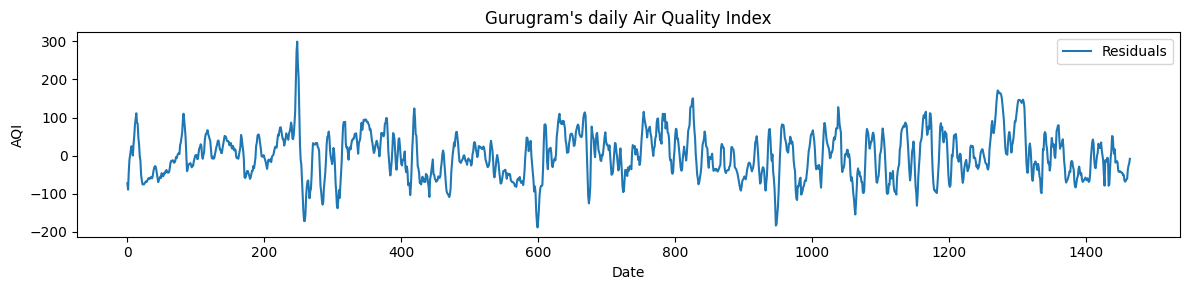

Model: PROPHET
SSE: 5158907.4744
R2: 0.6646
DW: 0.1178
AIC: 11978.1054
BIC: 12015.1327


In [ ]:
statistics["model"].append("prophet")

# SSE
prophet_residuals = train_df_prophet["y"].values - prophet_preds["yhat"].values
statistics["sse"].append((prophet_residuals ** 2).sum())

# R2
statistics["r2"].append(r2_score(train_df_prophet["y"], prophet_preds["yhat"]))

# DW
statistics["dw"].append(durbin_watson(prophet_residuals))

# AIC, BIC
prophet_n = len(train_df_prophet)
prophet_rss = np.sum((train_df_prophet["y"] - prophet_preds["yhat"])**2)
prophet_k = len(prophet.params) #if hasattr(prophet, "params") else 10

statistics["aic"].append(prophet_n * np.log(prophet_rss / prophet_n) + 2 * prophet_k)
statistics["bic"].append(prophet_n * np.log(prophet_rss / prophet_n) + prophet_k * np.log(prophet_n))

plot_time_series(prophet_residuals, label="Residuals")
for k, v in statistics.items():
  if k == "model":
    print(f"{k.capitalize()}: {v[1].upper()}")
    continue
  if len(v) != 0:
    print(f"{k.upper()}: {float(v[1]):.4f}")

#### SARIMA

Розділимо датасет на вибірки для тренування та тестування моделі SARIMAX. Виконаємо ресемплінг даних (перетворимо дані з щоденних на щотижневі) для зменшення обчислювальної складності. Відобразимо отримані дані.

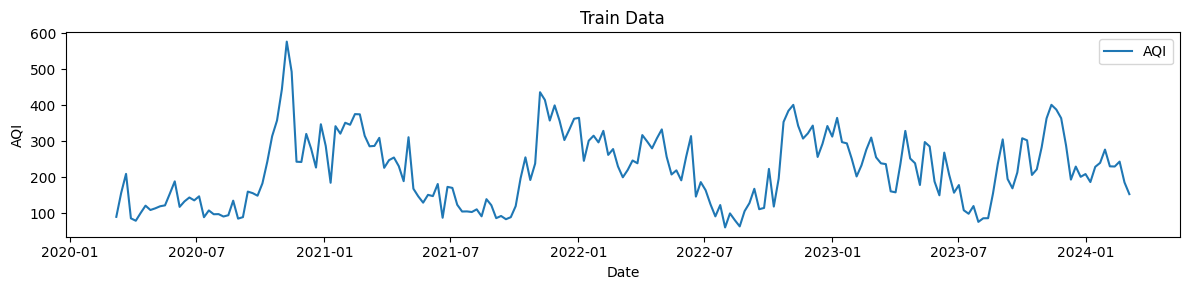

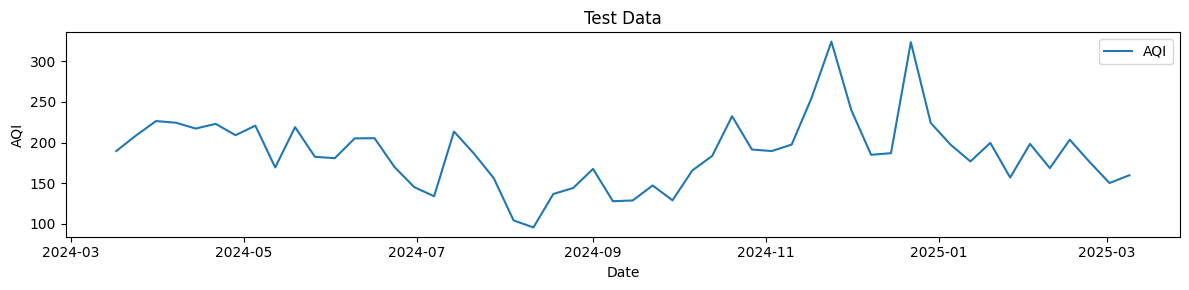

In [ ]:
sarimax_df = df.resample('W').mean()

sarimax_test_size = 52
sarimax_train_size = len(sarimax_df) - sarimax_test_size
sarimax_train_df = sarimax_df[:sarimax_train_size-1]
sarimax_test_df = sarimax_df[sarimax_train_size:]

plot_time_series(sarimax_train_df["Smoothed"], title="Train Data")
plot_time_series(sarimax_test_df["Smoothed"], title="Test Data")

Побудуємо для даних моделі SARIMA графіки ACF та PACF.

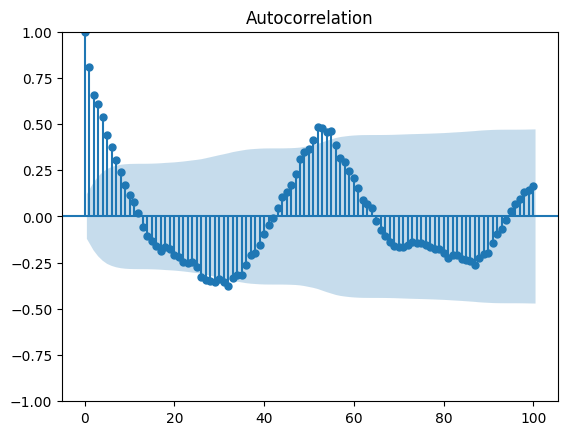

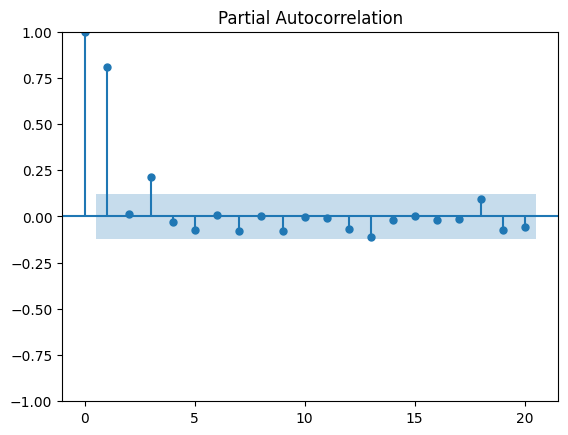

In [ ]:
plot_acf(sarimax_df["Smoothed"], lags=100)
plt.show()

plot_pacf(sarimax_df["Smoothed"], lags=20)
plt.show()

Проведемо тренування моделі та відобразимо результат прогнозування на тренувальних даних. Встановимо параметри моделі відповідно до графіків ACF та PACF, а також з урахуванням відсутності тренду в даних.

Optimization terminated successfully.
         Current function value: 5.405905
         Iterations: 7
         Function evaluations: 476


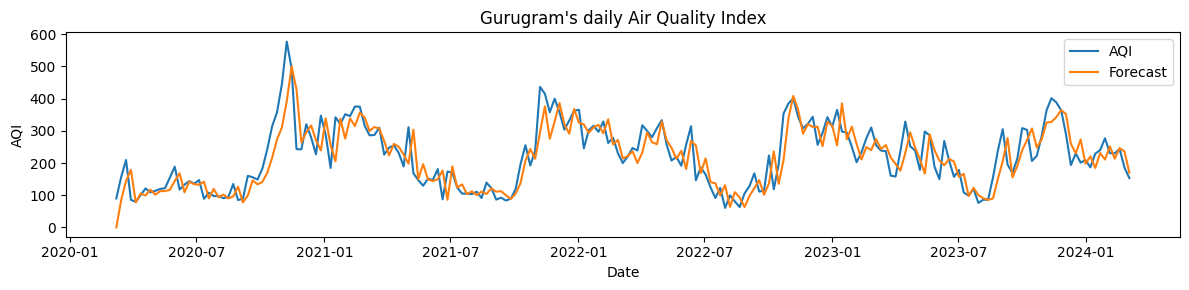

In [ ]:
sarimax = SARIMAX(
    sarimax_train_df["Smoothed"],
    order=(1, 0, 2),
    seasonal_order=(1, 0, 1, 52),
    enforce_stationarity=True,
    enforce_invertibility=False
)
sarimax_fit = sarimax.fit(method="powell")

sarimax_preds = sarimax_fit.predict(start=0, end=len(sarimax_train_df) - 1)
plot_time_series(sarimax_train_df["Smoothed"], forecast=sarimax_preds)

Виконаємо оцінювання моделі за наступними критеріями: сума квадратів похибок (SSE), коефіцієнт детермінації (R2), критерій Дарбіна-Уотсона (DW), критерій Акаіке (AIC), критерій Шварца (BIC). Також відобразимо графік залишків.

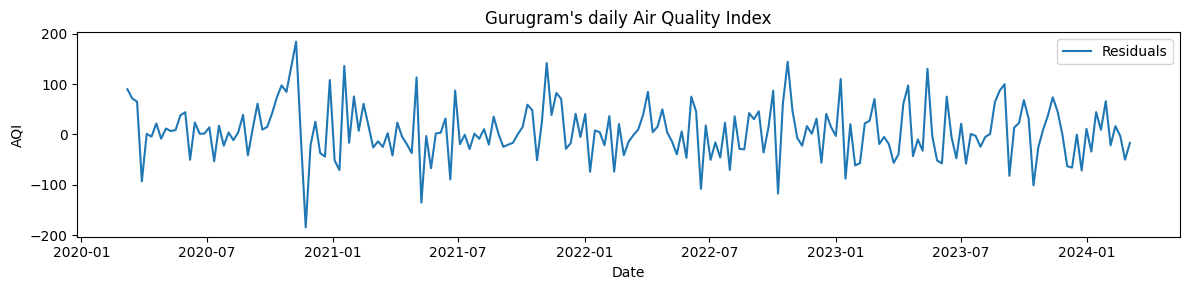

Model: SARIMAX
SSE: 612989.4561
R2: 0.6936
DW: 1.9618
AIC: 2271.6682
BIC: 2291.7222


In [ ]:
statistics["model"].append("sarimax")

# SSE
sarimax_residuals = sarimax_fit.resid
statistics["sse"].append((sarimax_residuals ** 2).sum())

# R2
statistics["r2"].append(r2_score(sarimax_train_df["Smoothed"], sarimax_preds))

# DW
statistics["dw"].append(durbin_watson(sarimax_residuals))

# AIC, BIC
statistics["aic"].append(sarimax_fit.aic)
statistics["bic"].append(sarimax_fit.bic)

plot_time_series(sarimax_residuals, label="Residuals")
for k, v in statistics.items():
  if k == "model":
    print(f"{k.capitalize()}: {v[2].upper()}")
    continue
  if len(v) != 0:
    print(f"{k.upper()}: {float(v[2]):.4f}")

###Побудова прогнозу та перевірка показників якості прогнозу

Напишемо функцію для оцінювання прогнозів моделей. Оцінюватимемо такі показники: середньоквадратична похибка (MSE), середня абсолютна похибка (MAE), середня абсолютна відсоткова похибка (MAPE).

In [ ]:
def evaluate_forecast(true, predicted):
  # MSE
  mse = mean_squared_error(true, predicted)
  # MAE
  mae = mean_absolute_error(true, predicted)
  # MAPE
  y_true = true.values
  y_pred = predicted.values

  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  return mse, mae, mape

Отримаємо прогноз моделі Хольта-Вінтерса на тестових даних, відобразимо та оцінимо його.

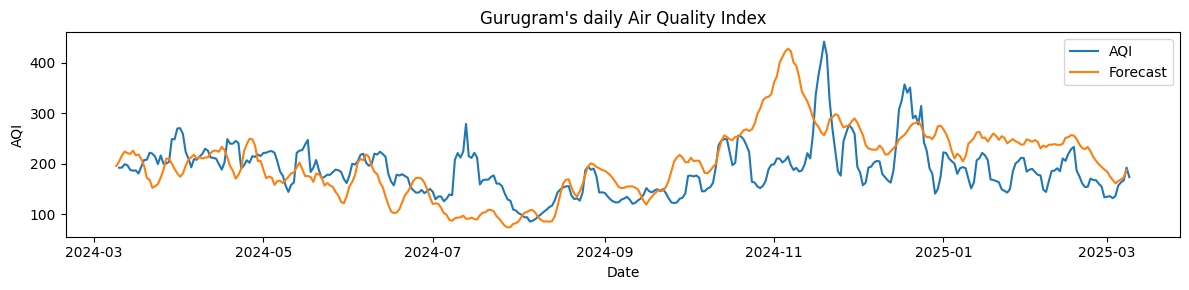

HOLT-WINTERS: MSE: 4296.68, MAE: 49.22, MAPE: 26.93%


In [ ]:
hw_forecast = hw_fit.forecast(steps=365)
plot_time_series(hw_test_df["Smoothed"], forecast=hw_forecast)

mse, mae, mape = evaluate_forecast(hw_test_df["Smoothed"], hw_forecast)
statistics["mse"].append(mse)
statistics["mae"].append(mae)
statistics["mape"].append(mape)
print(f"HOLT-WINTERS: MSE: {mse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

Отримаємо прогноз моделі Prophet на тестових даних, відобразимо та оцінимо його.

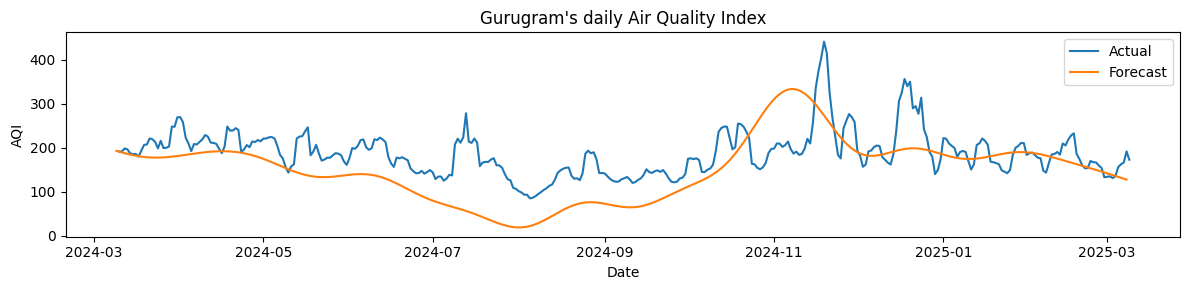

PROPHET: MSE: 4690.96, MAE: 55.30, MAPE: 30.96%


In [ ]:
future = prophet.make_future_dataframe(periods=365)
prophet_forecast = prophet.predict(future).set_index("ds")
plot_time_series(test_df_prophet.set_index("ds")["y"], label="Actual", forecast=prophet_forecast["yhat"][len(train_df_prophet):])

mse, mae, mape = evaluate_forecast(test_df_prophet["y"], prophet_forecast["yhat"][len(train_df_prophet):])
statistics["mse"].append(mse)
statistics["mae"].append(mae)
statistics["mape"].append(mape)
print(f"PROPHET: MSE: {mse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

Отримаємо прогноз моделі SARIMAX на тестових даних, відобразимо та оцінимо його.

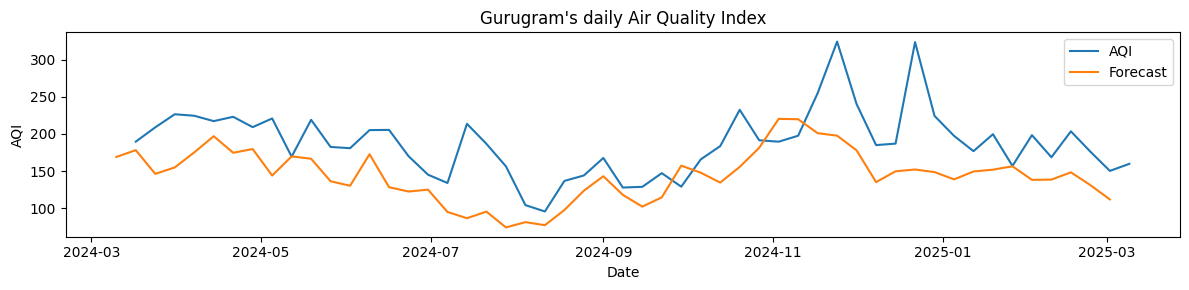

SARIMAX: MSE: 3020.31, MAE: 44.37, MAPE: 22.61%


In [ ]:
sarimax_forecast = sarimax_fit.forecast(steps=52)
plot_time_series(sarimax_test_df["Smoothed"], forecast=sarimax_forecast)

mse, mae, mape = evaluate_forecast(sarimax_test_df["Smoothed"], sarimax_forecast)
statistics["mse"].append(mse)
statistics["mae"].append(mae)
statistics["mape"].append(mape)
print(f"SARIMAX: MSE: {mse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

###Статистичні характеристики

Відобразимо усі статистичні характеристики моделей, розглянутих у роботі.

In [ ]:
results = pd.DataFrame(statistics)
results

,model,sse,r2,dw,aic,bic,mse,mae,mape
0,holt-winters,4.555430e+05,0.970386,0.942200,8428.565174,8481.461280,4296.678558,49.223914,26.931586
1,prophet,5.158907e+06,0.664630,0.117751,11978.105426,12015.132699,4690.962426,55.295943,30.955061
2,sarimax,6.129895e+05,0.693641,1.961778,2271.668202,2291.722208,3020.307584,44.366751,22.612806


##Висновок

Під час лабораторної роботи було проведено дослідження методів прогнозування часового ряду, що відображає значення індексу якості повітря (AQI) для міста Гуруграм (Індія). Ряд є стаціонарним, демонструє гетероскедастичність та має чітко виражену сезонність із річним періодом. Для побудови прогнозних моделей були використані три підходи: модель Хольта-Вінтерса (Holt-Winters), модель Prophet та SARIMAX.

Для моделі SARIMAX дані були попередньо агреговані до щотижневої частоти, з річною сезонністю, що відповідала 52 тижням. Інші моделі працювали з щоденними даними та річною сезонністю в 365 днів. Якість моделей оцінювалась за рядом метрик на тренувальному наборі: показники SSE, R2, коефіцієнт Дарбіна-Уотсона (DW), критерії Акаіке (AIC) та Шварца (BIC). Якість прогнозу була оцінена на тестовому наборі за наступними метриками: середньоквадратична помилка (MSE), середня абсолютна помилка (MAE) та середня абсолютна відносна помилка (MAPE).

Найкращі результати на тестовому наборі показала модель SARIMAX. Також вона має найнижчі значення AIC і BIC. Модель Хольта-Вінтерса показала найвищий коефіцієнт детермінації R2 (0.97), тобто найкраще відтворила тренувальні дані, але має гірші показники на тестовому наборі, ніж у SARIMAX. Модель Prophet продемонструвала найгірші результати як на тренувальному, так і на тестовому наборі, особливо з огляду на дуже низький коефіцієнт Дарбіна-Уотсона (0.12), що вказує на наявність автокореляції залишків.

Найбільш збалансовані та точні результати показала модель SARIMAX, яка забезпечила хорошу апроксимацію як тренувального, так і тестового набору даних. Вона є оптимальним вибором для цього типу сезонного стаціонарного ряду. Але з огляду на складність моделі та час тренування, кращим вибором буде модель Хольта-Вінтерса.

## Джерела даних
Gurugram's Air Quality Index Time-Series Dataset отримано з Kaggle:  
https://www.kaggle.com/datasets/pranaii/test-aqi?select=sector_51_daily_aqi.csv.